In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from pmdarima.arima import auto_arima

csv_file_path = os.path.join(os.getcwd(), '../', 'data','new_filtered_data.csv')
df = pd.read_csv(csv_file_path).iloc[::-1]
df.drop('Net', axis=1, inplace=True)

### Checking the ideal paramters for ARIMA

In [3]:
model = auto_arima(df['Close'], seasonal=False, trace=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2332.580, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2335.382, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2331.354, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2331.112, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2333.389, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2333.112, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2333.112, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=2329.118, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2331.118, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=2331.118, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=2329.360, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.19 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.222 seconds
                               S

Best model:  ARIMA(0,1,1)(0,0,0)[0]   

### Split the dataset

In [4]:
close_values = df['Close'].values

# we try the variation: 80-20
size = int(len(close_values) * 0.8)
train = close_values[:size]
test = close_values[size:]

In [5]:
from statsmodels.tsa.arima.model import ARIMA

def arima_forecast(history):
    model = ARIMA(history, order=(0,1,1))
    model_fit = model.fit()
    
    output = model_fit.forecast()
    yhat = output[0]
    return yhat

history = train.tolist()
predictions = list()

for t in range(len(test)):
    # Generate a prediction
    yhat = arima_forecast(history)
    predictions.append(yhat)
    # Add the predicted value to the training set
    obs = test[t]
    history.append(obs)

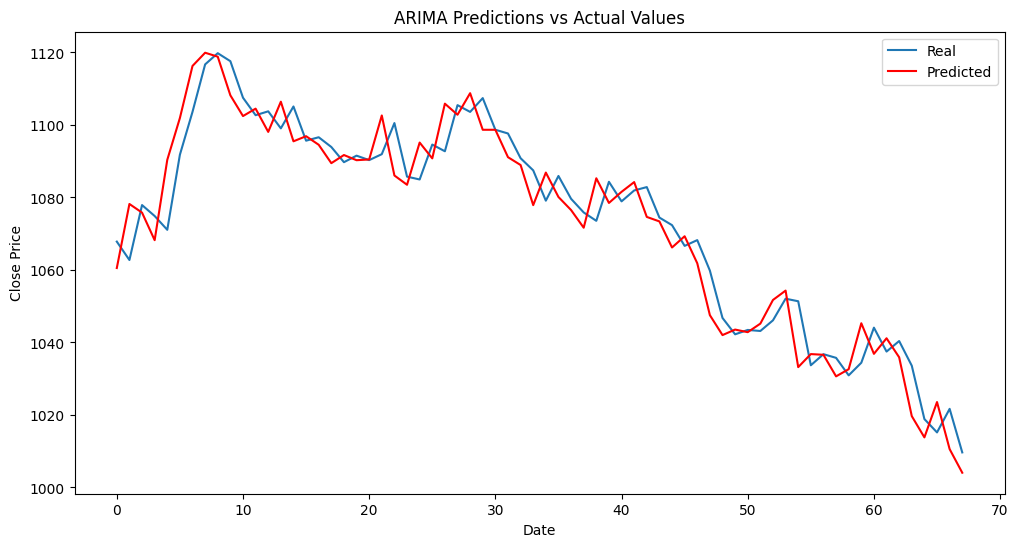

In [6]:
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(df.iloc[size:].index, test, label='Real')
plt.plot(df.iloc[size:].index, predictions, color='red', label='Predicted')
plt.title('ARIMA Predictions vs Actual Values')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [7]:
from sklearn.metrics import mean_squared_error

# Calculate RMSE
def compute_rmse(test, predictions):
    rmse = np.sqrt(mean_squared_error(test, predictions))
    print("RMSE:", rmse)

compute_rmse(test, predictions)

RMSE: 7.549948537399214


### Test for our target 5 days

In [8]:
x_test = pd.DataFrame([1112.34, 1102.34, 1088.62, 1091.21, 1077.11][::-1])

x_train = []

x_train.append(close_values[-15:]) # the last 15 days (ratio: 75-25 for train-test)
x_train.append(close_values[-20:]) # the last 20 days (ratio: 80-20 for train-test)
x_train.append(close_values[-29:]) # the last 45 days (ratio: 85-15 for train-test)
x_train.append(close_values[-45:]) # the last 45 days (ratio: 90-10 for train-test)

In [9]:
close_values = df['Close'].values

x_train = []
x_train.append(close_values)

RMSE: 10.260420023566693


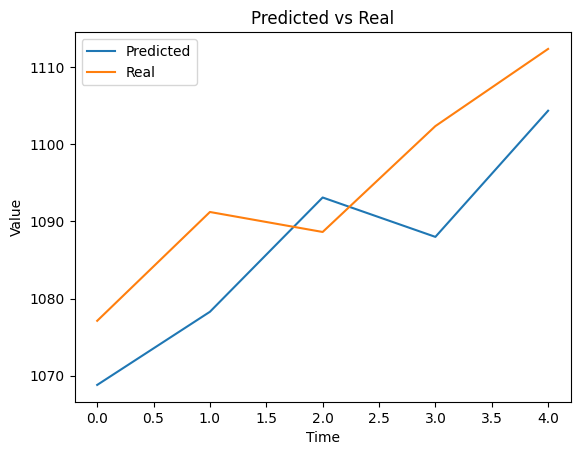

In [10]:
for train_list in x_train:
    history = train_list
    predictions = list()

    for t in range(len(x_test)):
        # Generate a prediction
        yhat = arima_forecast(history)
        predictions.append(yhat)
        # Add the predicted value to the training set
        obs = x_test.iloc[t, 0]  # Extracting the value from the DataFrame
        history = np.concatenate([history, [obs]])

    compute_rmse(x_test, predictions)

    plt.plot(x_test.index, predictions, label='Predicted')
    plt.plot(x_test.index, x_test.values, label='Real')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title('Predicted vs Real')
    plt.legend()
    plt.show()

RMSE: 10.260420023566693


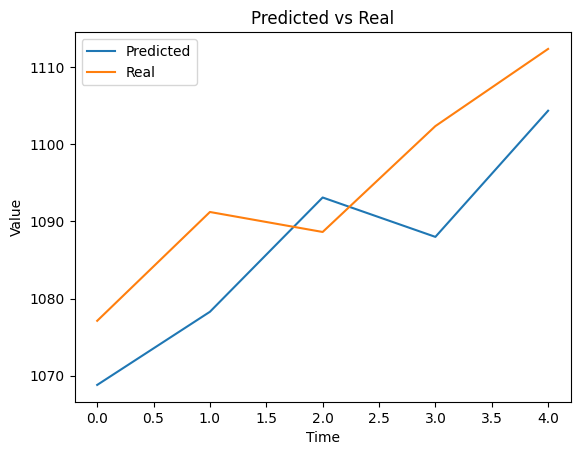

In [11]:
for train_list in x_train:
    history = train_list
    predictions = list()

    for t in range(len(x_test)):
        # Generate a prediction
        yhat = arima_forecast(history)
        predictions.append(yhat)
        # Add the predicted value to the training set
        obs = x_test.iloc[t, 0]  # Extracting the value from the DataFrame
        history = np.concatenate([history, [obs]])

    compute_rmse(x_test, predictions)

    plt.plot(x_test.index, predictions, label='Predicted')
    plt.plot(x_test.index, x_test.values, label='Real')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title('Predicted vs Real')
    plt.legend()
    plt.show()

In [15]:
df = pd.read_csv('to_predict.csv', parse_dates=['Exchange Date'])

df['Close'] = predictions

df.to_csv((os.getcwd(), '../', 'data','arima_output.csv'), index=False)